In [1]:
import random
import copy
import numpy as np
import pyspiel
from open_spiel.python.algorithms import mcts, random_agent, minimax
from othello_game import OthelloGame, OthelloState
from MCTS import MCTS
from Arena import Arena
from Coach import Coach
from BasicModel import BasicModel
from NNet import NNetWrapper
from QNet import QNetWrapper
from QNet2 import QNet2Wrapper
from HybridQNet import HybridQNetWrapper
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as p_np
import torch
import qiskit
from IPython.display import display

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \gate{\mathrm{R_Y}\,(\mathrm{0})} & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \ctrl{1} & \qw & \qw & \qw & \targ \barrier[0em]{4} & \qw & \meter & \qw & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \gate{\mathrm{R_Y}\,(\mathrm{0})} & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \targ & \ctrl{1} & \qw & \qw & \qw & \qw & \qw & \meter & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \gate{\mathrm{R_Y}\,(\mathrm{0})} & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \qw & \targ & \ctrl{1} & \qw & \qw & \qw & \qw & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{3} :  } & \lstick{{q}_{3} :  } & \gate{\mathrm{R_Z}\,(\mathrm{0})

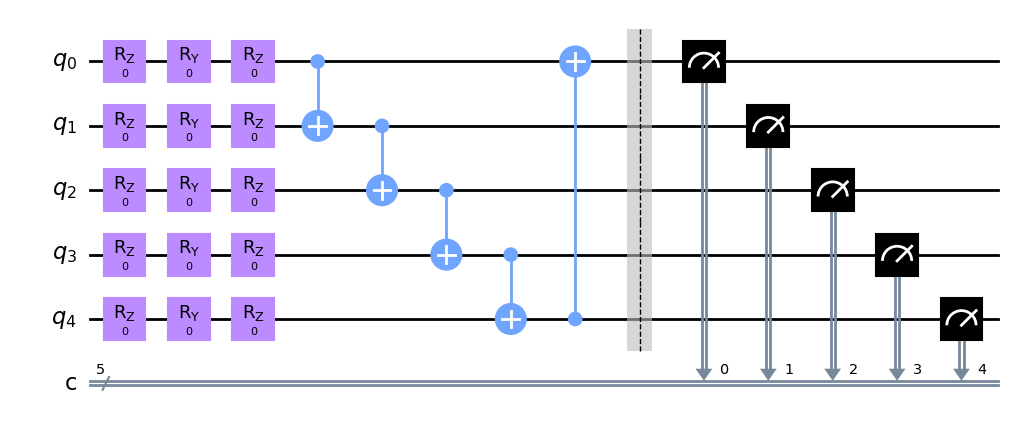

In [24]:
qubits = 5
dev = qml.device("qiskit.aer", wires=qubits)
@qml.qnode(dev)
def circuit(inputs, weights):
    inputs_1 = inputs / torch.sqrt(
        torch.max(
            torch.sum(inputs**2, axis=-1, dtype=torch.float64),
            torch.tensor(0.001, dtype=torch.float64),
        ).reshape(-1, 1)
    )
    # qml.StatePrep(inputs_1, wires=range(qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(qubits))
    # return qml.expval(qml.PauliZ(0))
    # make one measurement of qubit 0
    # draw barrier
    qml.Barrier(wires=range(qubits))
    return qml.expval(qml.PauliZ(0))
circuit(torch.ones((2**qubits), dtype=torch.float64), torch.zeros((1, qubits, 3) , dtype=torch.float64))
print(dev._circuit.draw(output='latex_source', fold=100))
dev._circuit.draw(output='mpl', fold=1000)

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{R_X}\,(\mathrm{1})} & \gate{\mathrm{R_Y}\,(\mathrm{1})} & \gate{\mathrm{R_Z}\,(\mathrm{1})} \barrier[0em]{5} & \qw & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \gate{\mathrm{R_Y}\,(\mathrm{0})} & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \ctrl{1} & \qw & \qw & \qw & \qw & \targ \barrier[0em]{5} & \qw & \meter & \qw & \qw & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \gate{\mathrm{R_X}\,(\mathrm{1})} & \gate{\mathrm{R_Y}\,(\mathrm{1})} & \gate{\mathrm{R_Z}\,(\mathrm{1})} & \qw & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \gate{\mathrm{R_Y}\,(\mathrm{0})} & \gate{\mathrm{R_Z}\,(\mathrm{0})} & \targ & \ctrl{1} & \qw & \qw & \qw & \qw & \qw & \qw & \meter & \qw & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \gate{\m

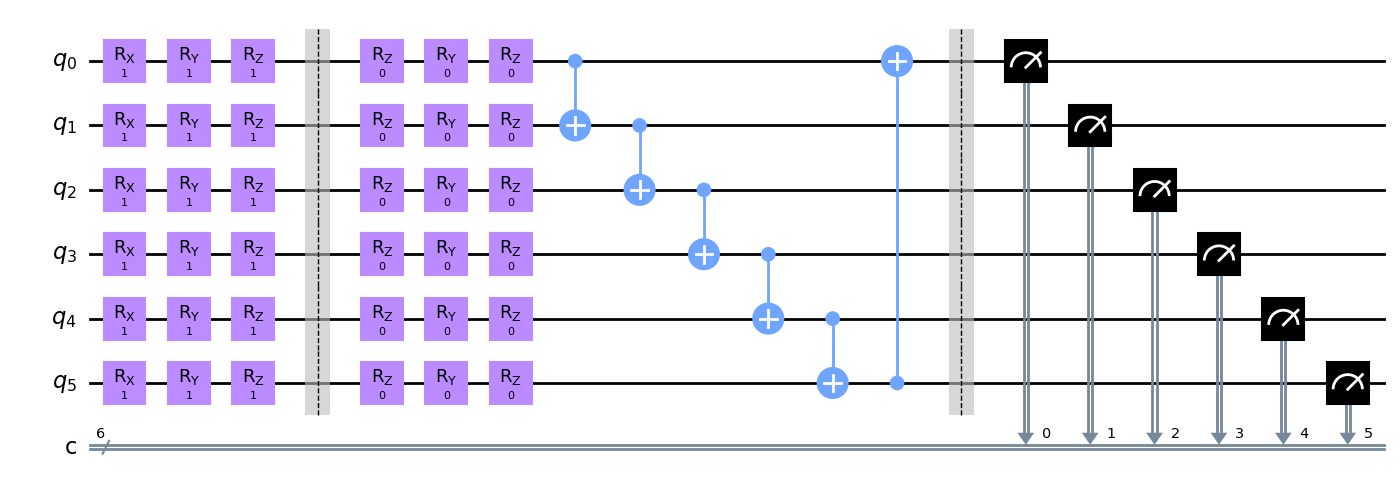

In [30]:
qubits = 6
dev = qml.device("qiskit.aer", wires=qubits)
@qml.qnode(dev)
def circuit(inputs, weights):
    """Quantum QVC Circuit"""

    inputs = inputs.reshape(-1, 3, qubits)
    # switch dimensions 0 and 1
    inputs = inputs.permute(1, 0, 2)

    qml.AngleEmbedding(inputs[0], wires=range(qubits), rotation="X")
    qml.AngleEmbedding(inputs[1], wires=range(qubits), rotation="Y")
    qml.AngleEmbedding(inputs[2], wires=range(qubits), rotation="Z")

    qml.Barrier(wires=range(qubits))

    qml.StronglyEntanglingLayers(weights, wires=range(qubits))

    qml.Barrier(wires=range(qubits))

    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]
circuit(torch.zeros((1, 3, 6), dtype=torch.float64), torch.zeros((1, qubits, 3) , dtype=torch.float64))
print(dev._circuit.draw(output='latex_source', fold=100))
dev._circuit.draw(output='mpl', fold=1000)